In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from torch import Tensor
import torch
import torch.nn as nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/competition_1st/data.zip'

# EDA

## 변수 설명
  - **int_rate** : 대출자에 부여된 이자율 (Interest rate of the loan the applicant received)
  - **annual_inc** : 연 소득 (annual income)
  - **dti** : 소득 대비 부채 비율 (Debt-to-income ratio)
  - **delinq_2yrs** : 지난 2년 간 체납 발생 횟수 (Delinquencies on lines of credit in the last 2 years)
  - **inq_last_6mths** : 지난 6개월 간 신용 조회 수 (Inquiries into the applicant's credit during the last 6 months)
  - **pub_rec** : 파산 횟수 (Number of bankruptcies listed in the public record)
  - **revol_bal** : 리볼빙 잔액 (Total credit revolving balance)
  - **total_acc** : 지금까지 소유했던 신용카드 개수 (num_total_cc_accounts : Total number of credit card accounts in the applicant's history)
  - **collections_12_mths_ex_med** : 의료부문을 제외한 지난 12개월 간 추심 발생 횟수 (num_collections_last_12m : Number of collections in the last 12 months. This excludes medical collections)
  - **acc_now_delinq** : 대출자가 체납 상태에 있지 않은 계좌의 수 (The number of accounts on which the borrower is now delinquent)
  - **tot_coll_amt** : 대출자에 대한 현재까지의 총 추심액 (total_collection_amount_ever : The total amount that the applicant has had against them in collections)
  - **tot_cur_bal** : 전 계좌의 현재 통합 잔고 (Total current balance of all accounts)
  - **chargeoff_within_12_mths** : 대출 부 신청인의 대출 신청 직전 12개월 간 세금 공제 횟수 (Number of charge-offs within last 12 months at time of application for the secondary applicant)
  - **delinq_amnt** : 체납 금액 (delinquency amount)
  - **tax_liens** : 세금 저당권의 수 (Number of tax liens)
  - **emp_length1 ~ 12** : 고용 연수 (Number of years in the job)
  - **home_ownership1 ~ 6** : 대출 신청자의 주거 소유 형태 (The ownership status of the applicant's residence)
  - **verification_status1 ~ 3** : 공동 소득 발생 여부 및 형태 (verification_income_joint : Type of verification of the joint income)
  - **purpose1 ~ 14** : 대출 목적 (The purpose of the loan)
  - **initial_list_status1 ~ 2** : 최초 대출 상태 (Initial listing status of the loan)
  - **mths_since_last_delinq1 ~ 11** : 마지막 체납이 지금으로부터 몇개월 전에 있었는지를 나타내는 변수 (Months since the last delinquency)
  
  - **funded_amnt** : 대출액 (Funded amount)
  - **funded_amnt_inv** : 사채 대출액 (Funded amount by investors)
  - **total_rec_late_fee** : 총 연체료 중 납부액 (Late fees received to date)
  - **term1** : 상환 기간 (The number of payments on the loan. Values are in months and can be either 36 or 60)
  - **open_acc** : 개설 개좌 수 (The number of open credit lines in the borrower's credit file)
  - **installment** : 대출 발생 시 월 상환액 (The monthly payment owed by the borrower if the loan originates)
  - **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율 (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit)
  - **out_prncp** : 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded)
  - **out_prncp_inv** : 사채 대출액 중 원리금 잔액 (Remaining outstanding principal for total amount funded by investors)
  - **total_rec_int** : 이자 상환액 (Interest received to date)
  - **fico_range_low** : FICO(일종의 신용점수) 최저값 (The lower boundary range the borrower’s FICO at loan origination belongs to)
  - **fico_range_high** : FICO(일종의 신용점수) 최고값 (The upper boundary range the borrower’s FICO at loan origination belongs to)
  
  - **depvar** : 고객의 부도 여부 (dependent variable)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [ ]:
df.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1


### 의사결정나무 특징 중요도 파악

In [ ]:
# Feature 중요도 구하기 위해 fitting
dcs_tree_clf = DecisionTreeClassifier(random_state=42)
dcs_tree_clf.fit(df.drop(columns=['depvar']), df['depvar'])

# Feature 중요도 구하기
def rnd_feat_importance(model, df):
    return pd.DataFrame({'cols':df.columns, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)

fi = rnd_feat_importance(dcs_tree_clf, df.drop(columns=['depvar']))

In [ ]:
# 상위 Top Feature 추출하기

def ext_top_feat(df, df_feat, num):
    ext_fi = df_feat[:num]
    col_list = ext_fi.cols
    col_list = list(col_list)
    col_list.append('depvar')
    df2 = df[col_list]
    return df2, col_list

df2, col_list = ext_top_feat(df, fi, 16)

### 추출된 features
- **int_rate** : 대출자에 부여된 이자율
- **annual_inc** : 연 소득 (annual income)
- **dti** : 소득 대비 부채 비율
- **inq_last_6mths** : 지난 6개월 간 신용 조회 수 X
- **revol_bal** : 리볼빙 잔액
- **total_acc** : 지금까지 소유했던 신용카드 개수
- **tot_cur_bal** : 전 계좌의 현재 통합 잔고
- **funded_amnt** : 대출액 (Funded amount)
- **funded_amnt_inv** : 사채 대출액
- **total_rec_late_fee** : 총 연체료 중 납부액
- **open_acc** : 개설 개좌 수
- **installment** : 대출 발생 시 월 상환액
- **revol_util** : 리볼빙 한도 대비 리볼빙 사용 비율
- **total_rec_int** : 이자 상환액
- **fico_range_low** : FICO(일종의 신용점수) 최저값 
- **fico_range_high** : FICO(일종의 신용점수) 최고값



In [ ]:
df2

,total_rec_int,int_rate,installment,tot_cur_bal,dti,annual_inc,revol_bal,revol_util,total_rec_late_fee,total_acc,open_acc,fico_range_low,funded_amnt_inv,fico_range_high,funded_amnt,inq_last_6mths,depvar
0,157.94,0.0824,37.74,11773,29.19,21000.0,3016,0.076,0.0,26,18,765,1200.0,769,1200,1,0
1,1702.42,0.1299,269.52,21875,4.82,80000.0,5722,0.447,0.0,24,8,665,8000.0,669,8000,1,0
2,1066.64,0.1299,168.45,31868,23.66,38000.0,6511,0.880,0.0,18,7,670,5000.0,674,5000,3,0
3,1256.24,0.1367,510.27,326049,16.27,100000.0,6849,0.457,0.0,30,12,680,15000.0,684,15000,2,1
4,871.04,0.1269,335.45,8840,25.28,30000.0,8197,0.416,0.0,12,8,660,10000.0,664,10000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5373.29,0.1757,718.75,26570,17.67,65000.0,11255,0.780,0.0,21,13,660,20000.0,664,20000,3,1
99996,835.66,0.0890,190.52,6138,2.88,65000.0,2105,0.120,0.0,12,7,765,6000.0,769,6000,0,0
99997,1261.67,0.1349,217.16,96531,32.12,46000.0,8998,0.643,0.0,20,19,665,6400.0,669,6400,1,0
99998,1357.69,0.2115,207.64,3875,4.53,31000.0,3875,0.731,0.0,4,3,710,5500.0,714,5500,1,1


In [ ]:
# max값 삽입해주기
df2.loc[df2['tot_cur_bal']>1200000, 'tot_cur_bal'] = 1200000
df2.loc[df2['annual_inc']>480000, 'annual_inc'] = 480000
df2.loc[df2['revol_bal']>290000, 'revol_bal'] = 290000
df2.loc[df2['revol_util']>1.785, 'revol_util'] = 1.785
df2.loc[df2['total_rec_late_fee']>53, 'total_rec_late_fee'] = 53
df2.loc[df2['total_acc']>89, 'total_acc'] = 89
df2.loc[df2['open_acc']>41, 'open_acc'] = 41

In [ ]:
# 구간 축약하기 // aux(auxiliary) = 보조의
# 결과를 보면 Feature importance가 그렇게 의미있는 것 같지 않음
# 구간 몰려있는 애들 뒤에 다 짤라서, 바로앞구간 max값으로 치환해주고 또 구간나눠서 보는게 의미있을것같은데
auxtotal_rec_int = pd.cut(df2['total_rec_int'], 6) #구간마다 1:2 구조임. 특징X
auxint_rate = pd.cut(df2['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
auxinstallment = pd.cut(df2['installment'], 15)  #특징 X
auxtot_cur_bal = pd.cut(df2['tot_cur_bal'], 10)  #뒤쪽으로 갈수록 1비율 낮음
auxdti = pd.cut(df2['dti'], 10)                # 뒤쪽으로 갈수록 0비율 높음 의미O
auxannual_inc = pd.cut(df2['annual_inc'], 10)  # 처음 1구간에 몰려있음
auxrevol_bal = pd.cut(df2['revol_bal'], 10)    # 처음 2구간에 몰려있음
auxrevol_util = pd.cut(df2['revol_util'], 10)  # 처음 2구간에 몰려있음
# auxtotal_rec_late_fee = pd.cut(df['total_rec_late_fee'], 10)  # 처음 1구간에 몰려있음
auxtotal_acc = pd.cut(df2['total_acc'], 10)    #특징 X
auxopen_acc = pd.cut(df2['open_acc'], 10)      #특징 X
auxfico_range_low = pd.cut(df2['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfunded_amnt_inv = pd.cut(df2['funded_amnt_inv'], 10)  #앞쪽일수록 0이 좀더 큰것같긴한데 미미함
auxfico_range_high = pd.cut(df2['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfunded_amnt = pd.cut(df2['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.
auxinq_last_6mths = pd.cut(df2['inq_last_6mths'], 7) #뒤로갈수록 1비율 높긴하네
# aux_list = [auxtotal_rec_int, auxint_rate, auxinstallment, 
#             auxtot_cur_bal, auxdti, auxannual_inc, auxrevol_bal, auxrevol_util,
#             auxtotal_acc, auxopen_acc, auxfico_range_low,
#             auxfunded_amnt_inv, auxfico_range_high, auxfunded_amnt]

In [ ]:
# qcut
# auxtotal_rec_int = pd.qcut(df['total_rec_int'], 6) #구간마다 1:2 구조임. 특징X
# auxint_rate = pd.qcut(df['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
# auxinstallment = pd.qcut(df['installment'], 15)  #특징 X
# auxtot_cur_bal = pd.qcut(df['tot_cur_bal'], 10)  #처음 2구간에 몰려있음 특징 X
# auxdti = pd.qcut(df['dti'], 10)                # 뒤쪽일수록 1비율 큼. 의미O
# auxannual_inc = pd.qcut(df['annual_inc'], 10)  # 처음 1구간에 몰려있음
# auxrevol_bal = pd.qcut(df['revol_bal'], 10)    # 처음 2구간에 몰려있음
# auxrevol_util = pd.qcut(df['revol_util'], 10)  # 처음 2구간에 몰려있음
# auxtotal_rec_late_fee = pd.cut(df['total_rec_late_fee'], 10)  # 처음 1구간에 몰려있음
# auxtotal_acc = pd.qcut(df['total_acc'], 10)    #특징 X
# auxopen_acc = pd.qcut(df['open_acc'], 10)      #특징 X
# auxfico_range_low = pd.cut(df['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
# auxfunded_amnt_inv = pd.qcut(df['funded_amnt_inv'], 10)  #앞쪽일수록 0이 좀더 큰것같긴한데 미미함
# auxfico_range_high = pd.cut(df['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
# auxfunded_amnt = pd.qcut(df['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.
# auxinq_last_6mths = pd.cut(df['inq_last_6mths'], 7) #뒤로갈수록 1비율 높긴하네

## 그래프 시각화

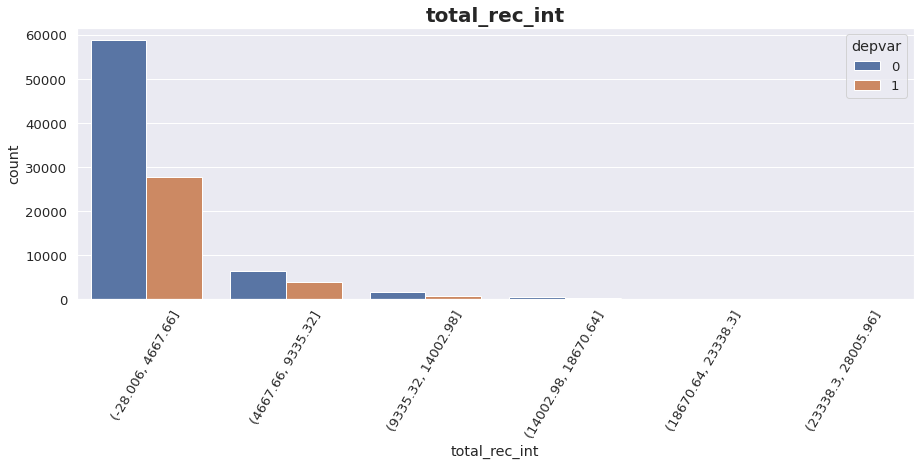

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtotal_rec_int, hue='depvar', data=df2).set_title("total_rec_int",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

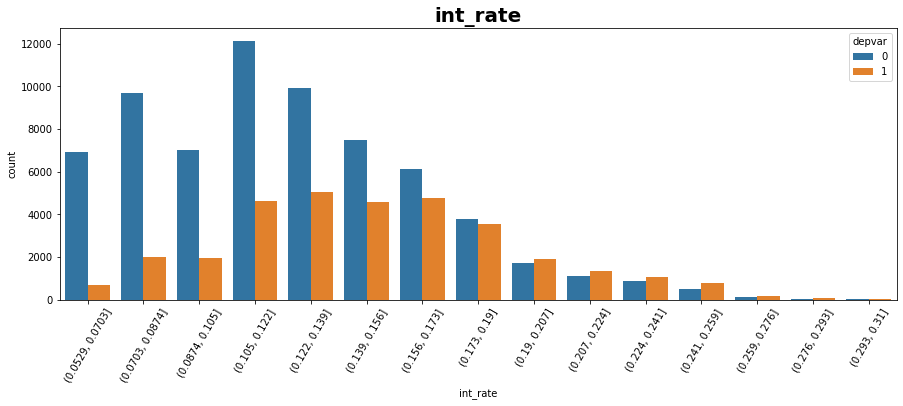

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxint_rate, hue='depvar', data=df2).set_title("int_rate",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

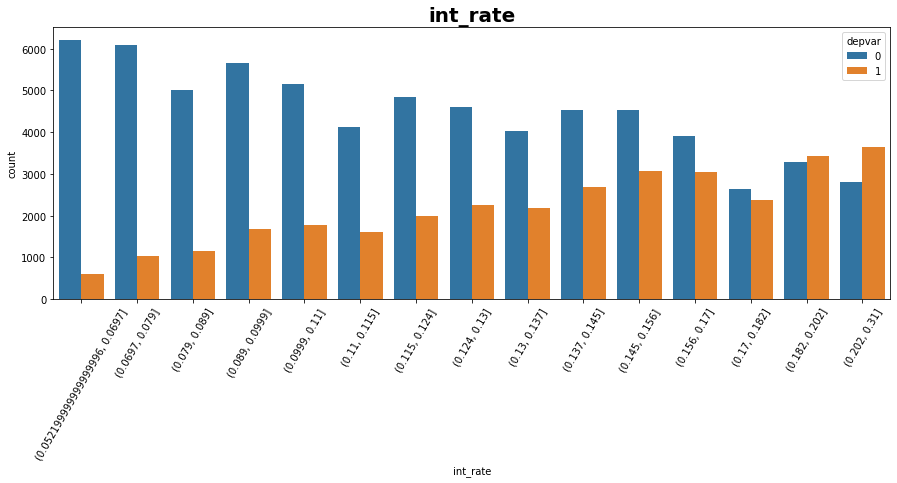

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxint_rate, hue='depvar', data=df2).set_title("int_rate",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

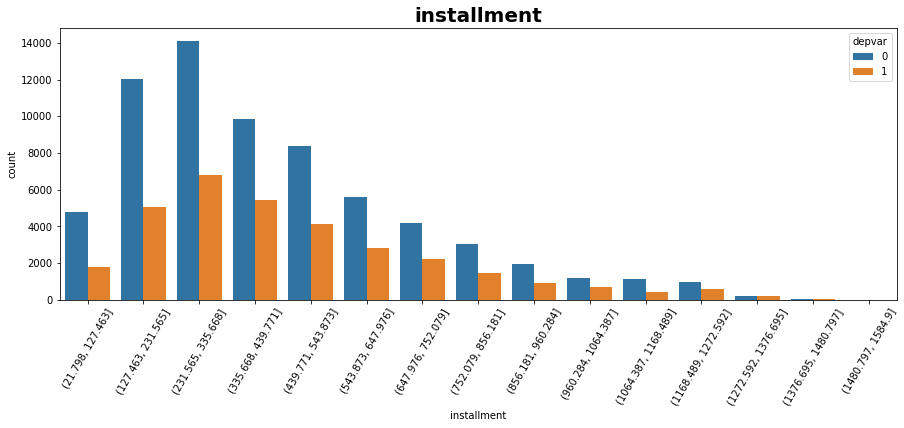

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxinstallment, hue='depvar', data=df2).set_title("installment",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

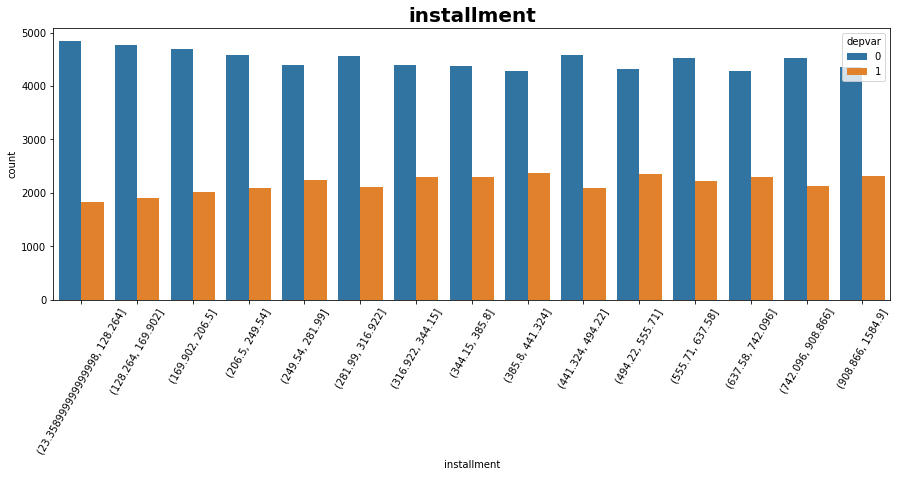

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxinstallment, hue='depvar', data=df2).set_title("installment",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

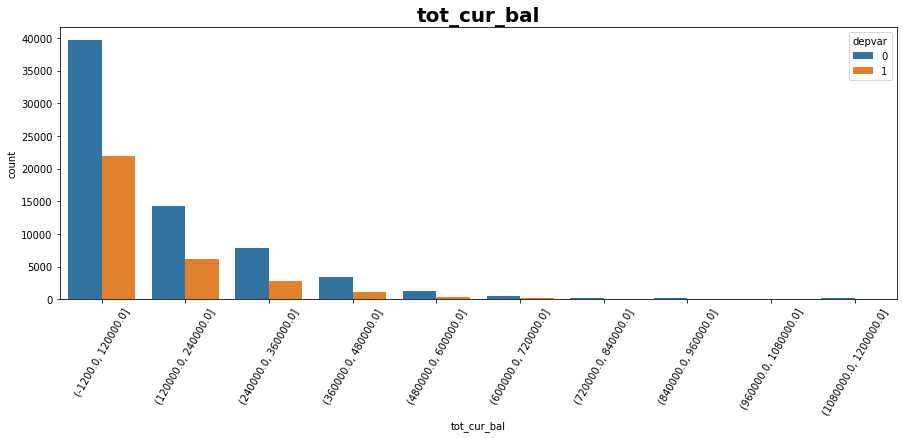

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtot_cur_bal, hue='depvar', data=df2).set_title("tot_cur_bal",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

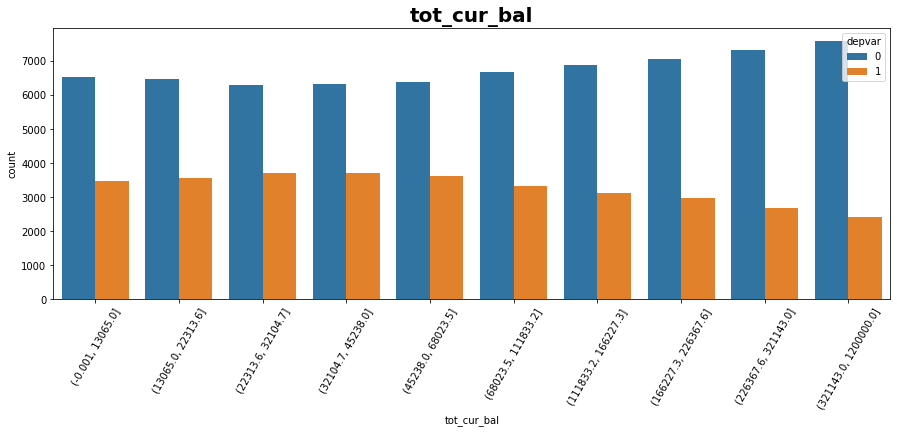

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtot_cur_bal, hue='depvar', data=df2).set_title("tot_cur_bal",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

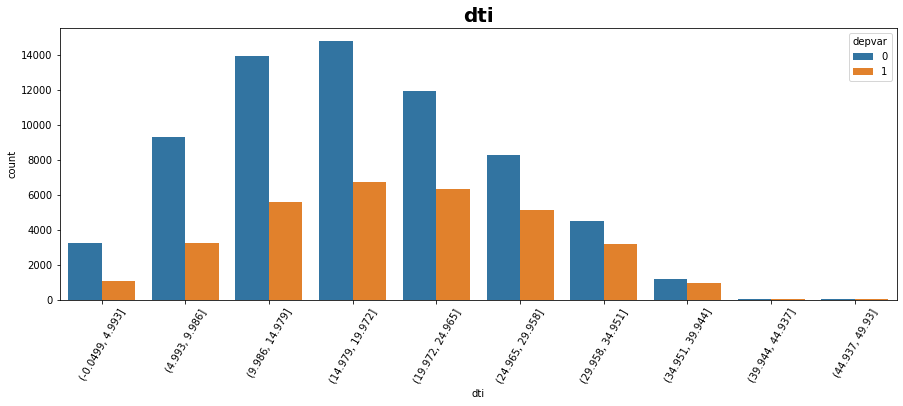

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxdti, hue='depvar', data=df2).set_title("dti",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

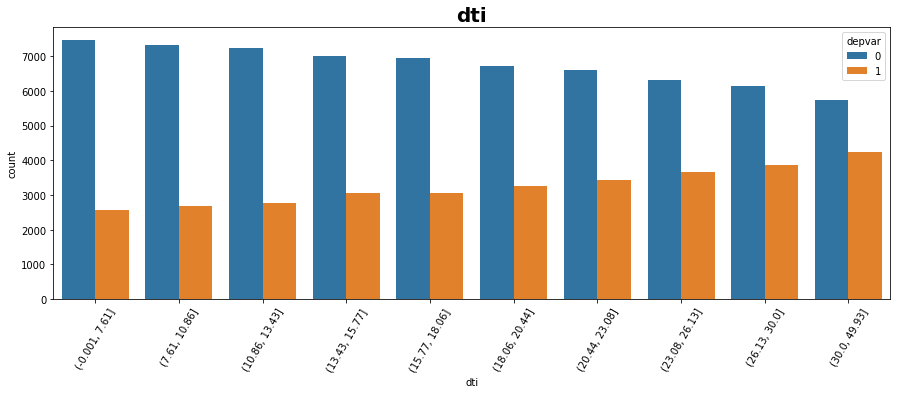

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxdti, hue='depvar', data=df2).set_title("dti",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

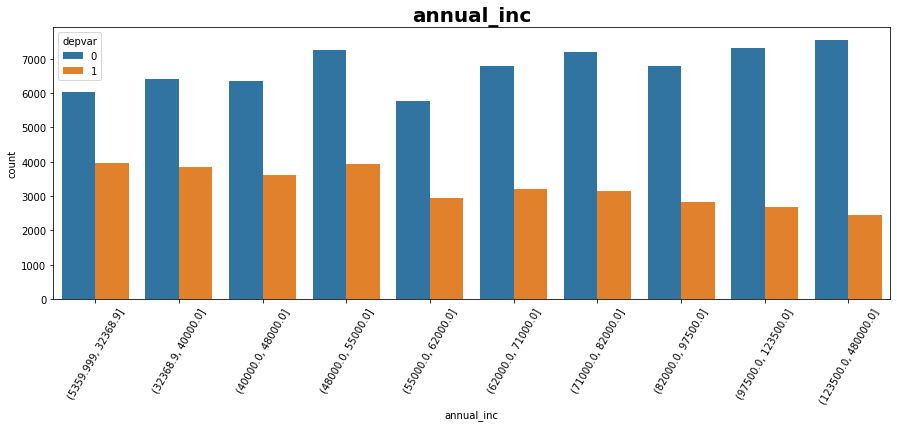

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxannual_inc, hue='depvar', data=df2).set_title("annual_inc",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

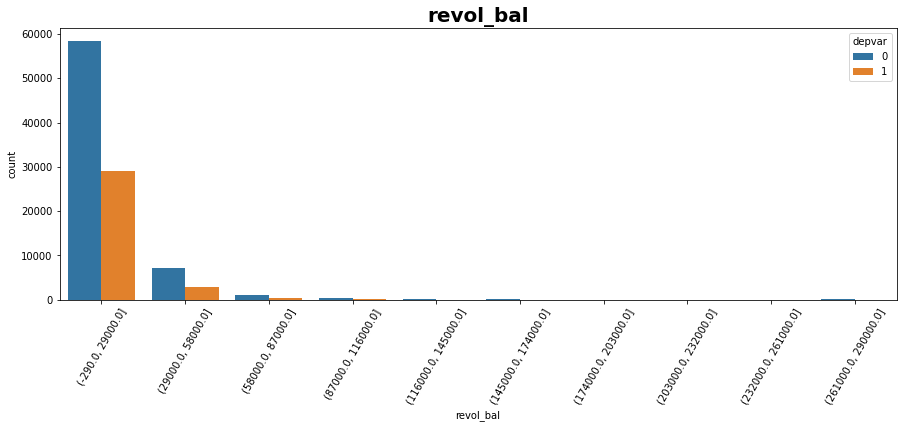

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxrevol_bal, hue='depvar', data=df2).set_title("revol_bal",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

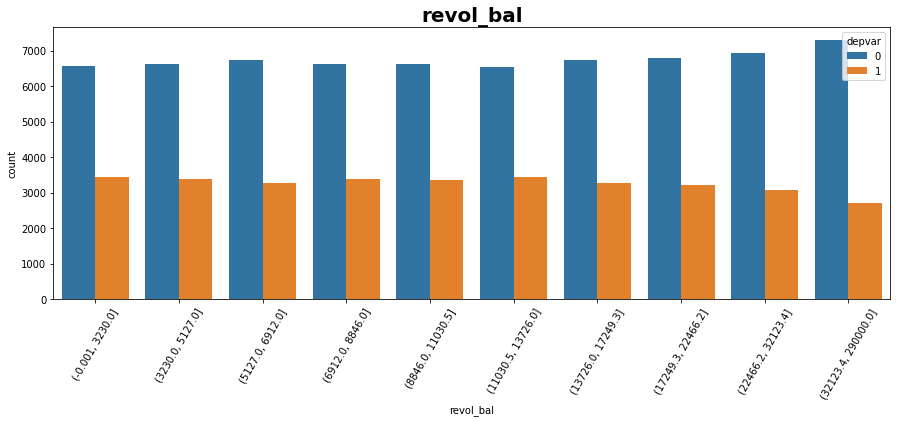

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxrevol_bal, hue='depvar', data=df2).set_title("revol_bal",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

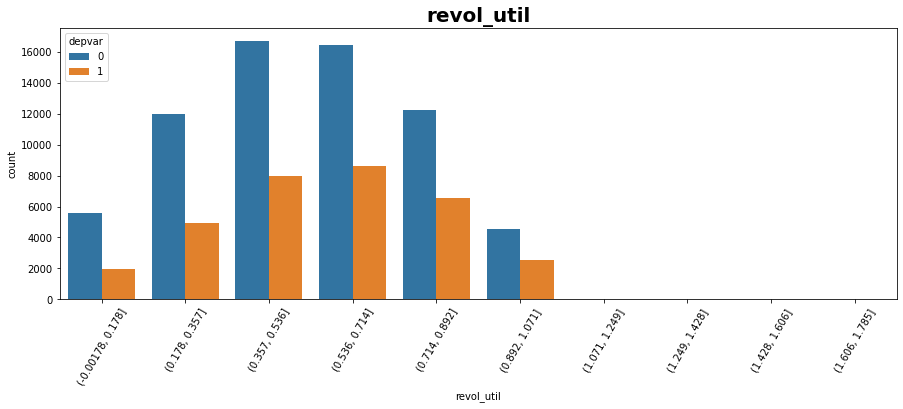

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxrevol_util, hue='depvar', data=df2).set_title("revol_util",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

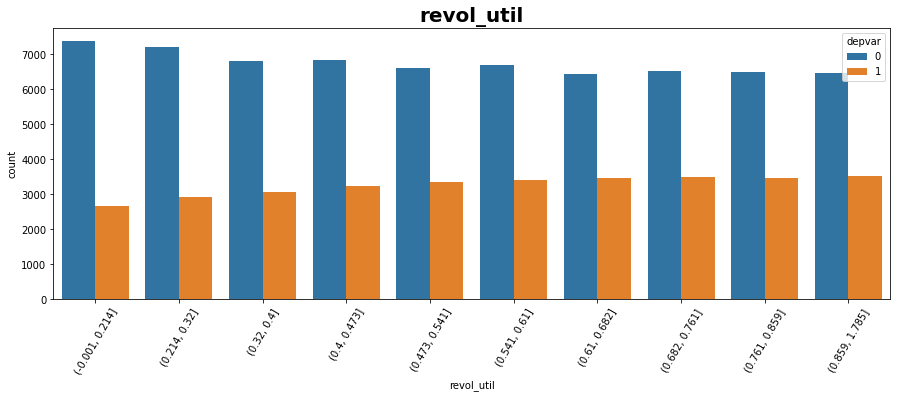

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxrevol_util, hue='depvar', data=df2).set_title("revol_util",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

### total_rec_late_fee 는 0.001이상일 경우 '1'비율이 확실히 높은 만큼 핵심적인 para인데 몰려있어서 수동으로 분류해줌

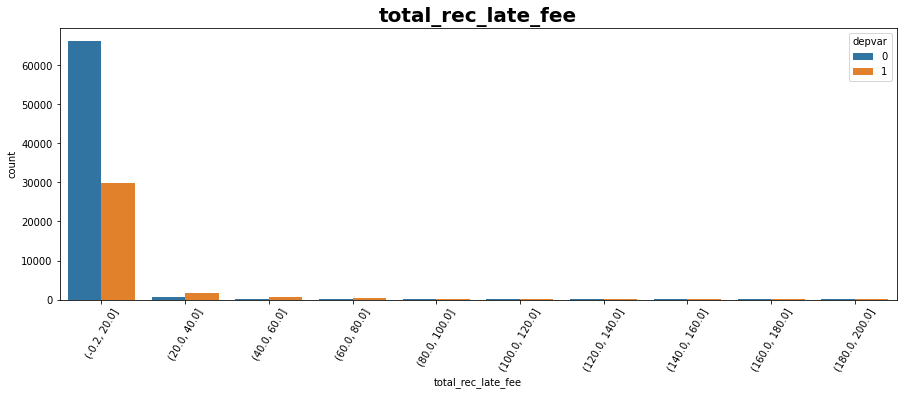

In [ ]:
# fig, axs = plt.subplots(figsize=(15, 5))
# sns.countplot(x=auxtotal_rec_late_fee, hue='depvar', data=df).set_title("total_rec_late_fee",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
# plt.xticks(rotation=60)
# plt.show()

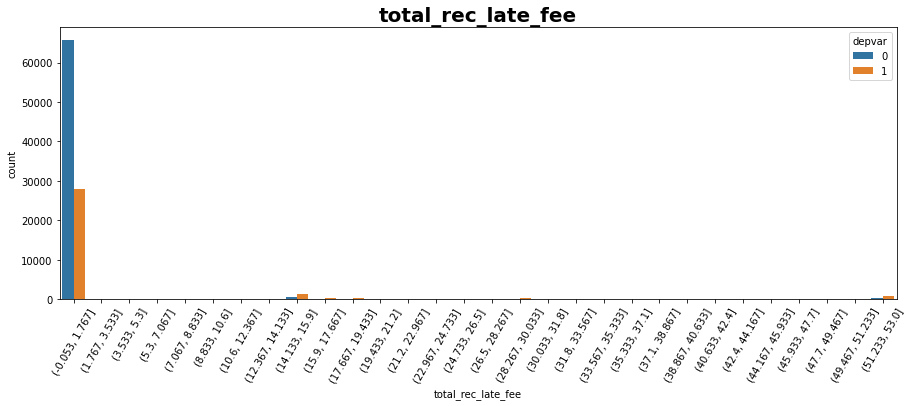

In [ ]:
auxtotal_rec_late_fee = pd.cut(df['total_rec_late_fee'], 30)
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtotal_rec_late_fee, hue='depvar', data=df2).set_title("total_rec_late_fee",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

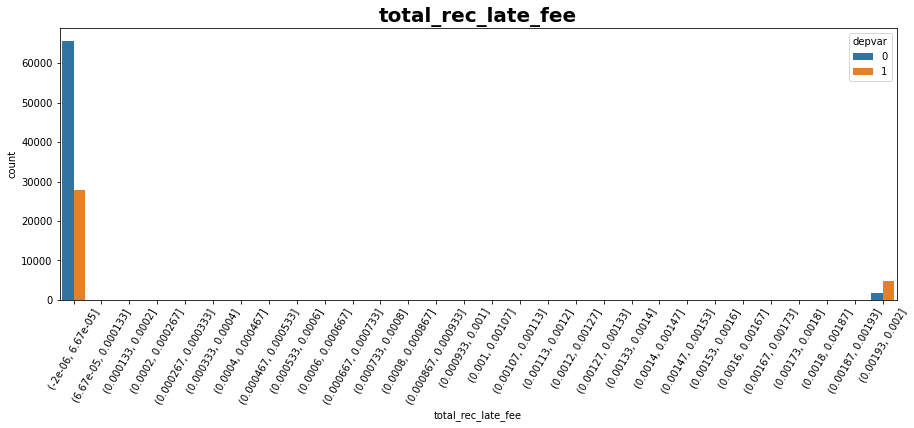

In [ ]:
df.loc[df['total_rec_late_fee']>0.002, 'total_rec_late_fee'] = 0.002
auxtotal_rec_late_fee = pd.cut(df['total_rec_late_fee'], 30)
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtotal_rec_late_fee, hue='depvar', data=df2).set_title("total_rec_late_fee",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

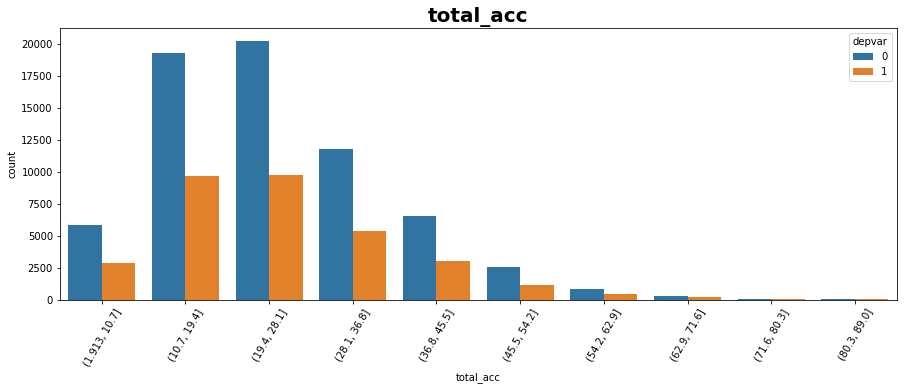

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtotal_acc, hue='depvar', data=df).set_title("total_acc",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

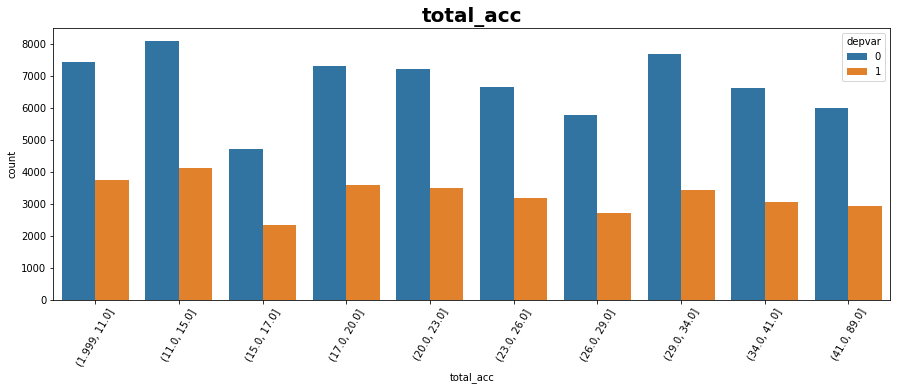

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtotal_acc, hue='depvar', data=df).set_title("total_acc",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

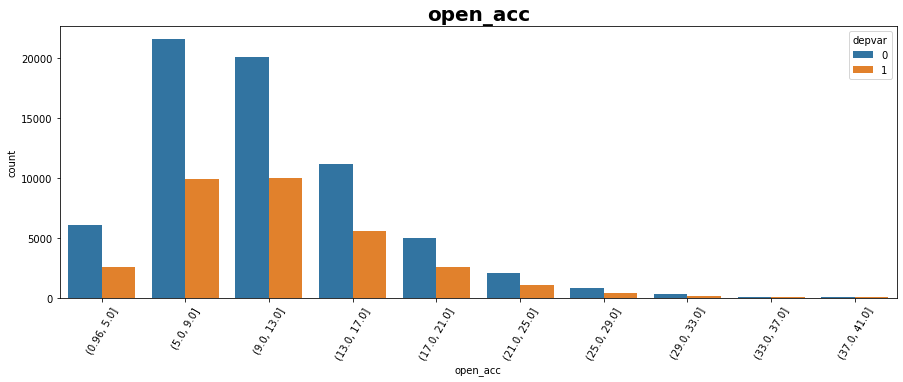

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxopen_acc, hue='depvar', data=df).set_title("open_acc",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

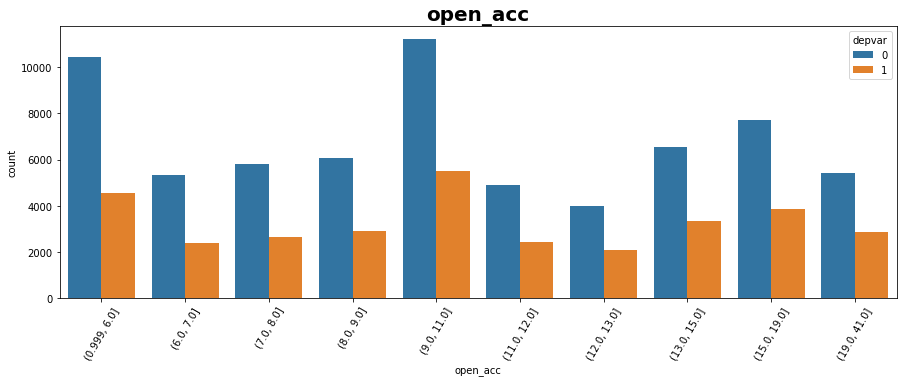

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxopen_acc, hue='depvar', data=df).set_title("open_acc",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

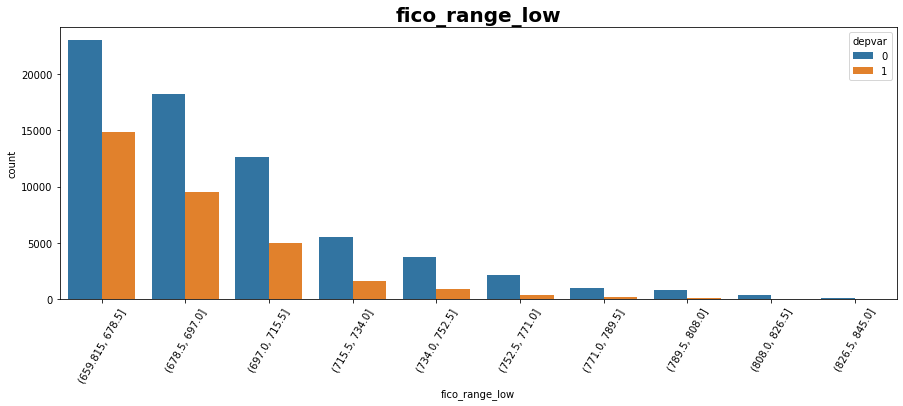

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfico_range_low, hue='depvar', data=df).set_title("fico_range_low",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

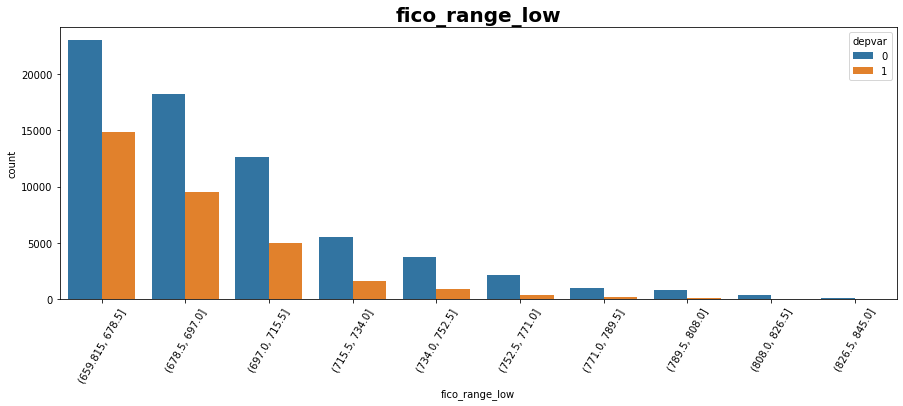

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfico_range_low, hue='depvar', data=df).set_title("fico_range_low",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

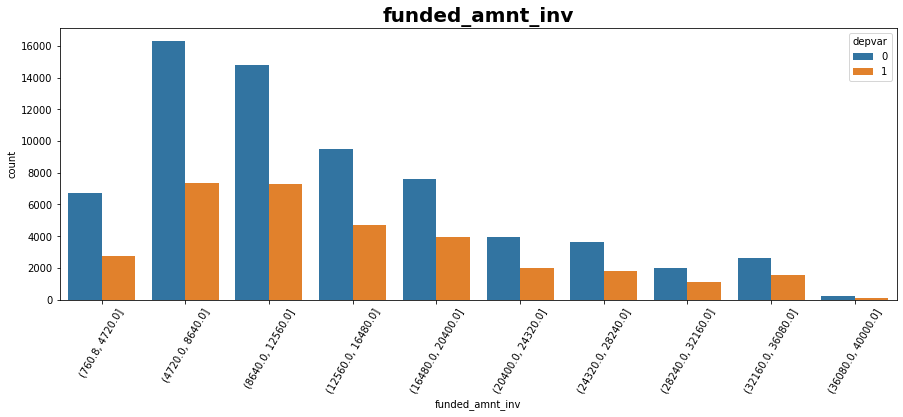

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfunded_amnt_inv, hue='depvar', data=df).set_title("funded_amnt_inv",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

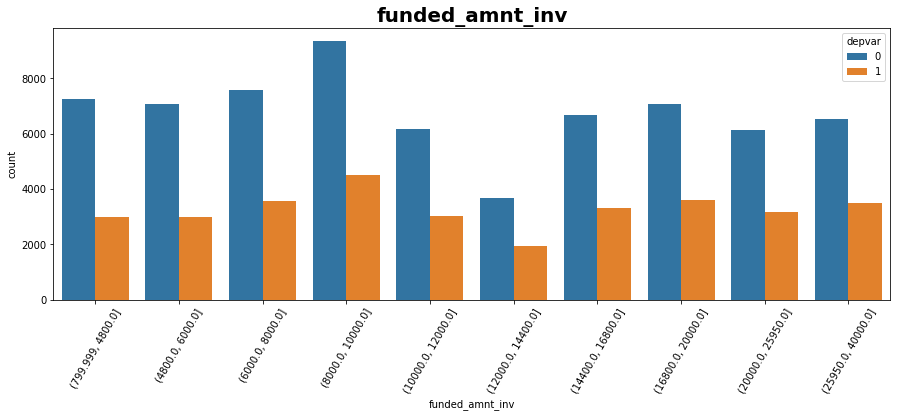

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfunded_amnt_inv, hue='depvar', data=df).set_title("funded_amnt_inv",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

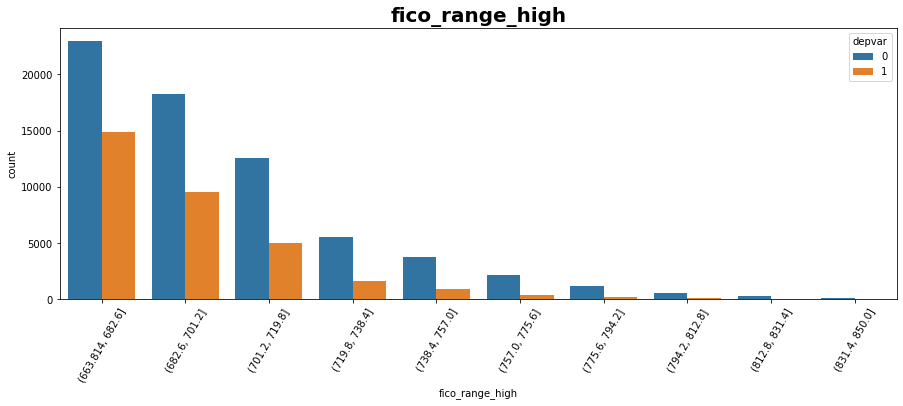

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfico_range_high, hue='depvar', data=df).set_title("fico_range_high",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

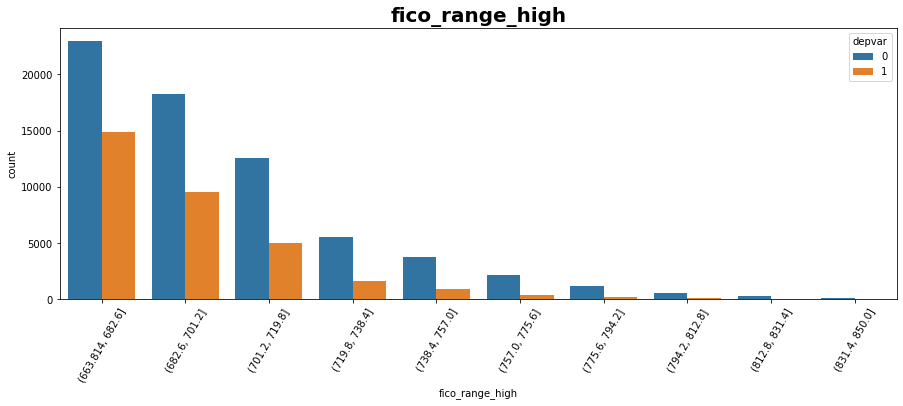

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfico_range_high, hue='depvar', data=df).set_title("fico_range_high",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

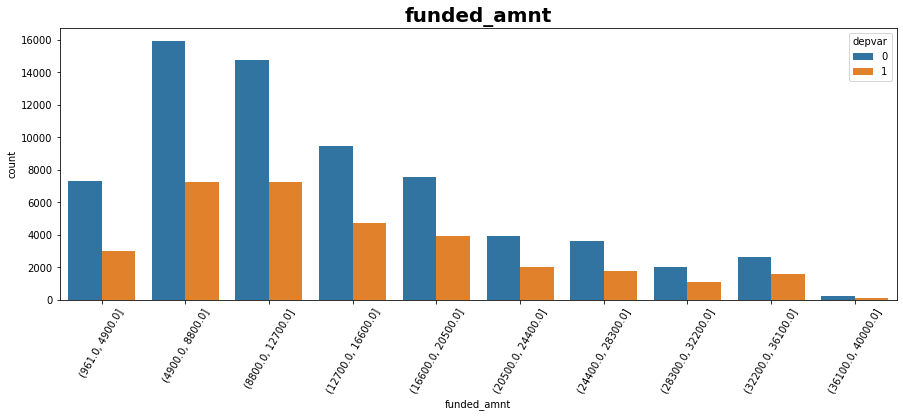

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfunded_amnt, hue='depvar', data=df).set_title("funded_amnt",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

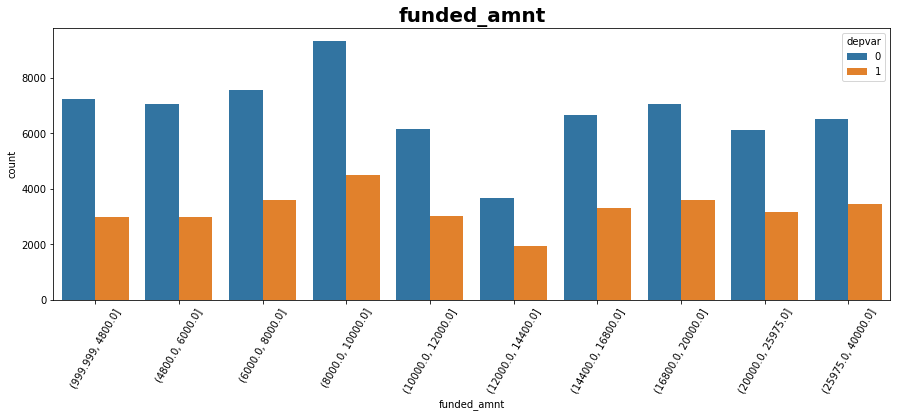

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxfunded_amnt, hue='depvar', data=df).set_title("funded_amnt",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

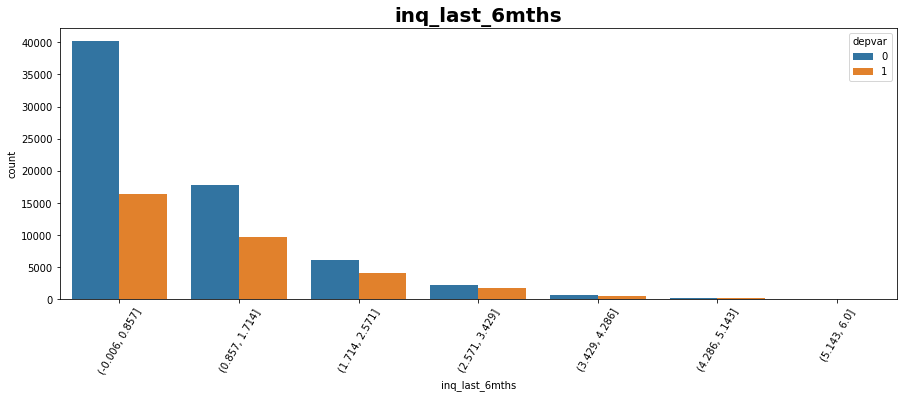

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxinq_last_6mths, hue='depvar', data=df).set_title("inq_last_6mths",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

## 시각화 한것 바탕으로 data 재가공

In [ ]:
## total_rec_fee 먼저 라벨링 6개정도
df2.loc[ df2['total_rec_late_fee'] <= 0.000001, 'total_rec_late_fee'] = 0
df2.loc[(df2['total_rec_late_fee'] > 0.000001) & (df2['total_rec_late_fee'] <= 0.002), 'total_rec_late_fee'] = 1
df2.loc[(df2['total_rec_late_fee'] > 0.002) & (df2['total_rec_late_fee'] <= 0.06), 'total_rec_late_fee'] = 2
df2.loc[(df2['total_rec_late_fee'] > 0.06) & (df2['total_rec_late_fee'] <= 1.7), 'total_rec_late_fee'] = 3
df2.loc[(df2['total_rec_late_fee'] > 1.7) & (df2['total_rec_late_fee'] <= 12), 'total_rec_late_fee'] = 4
df2.loc[df2['total_rec_late_fee']  > 12, 'total_rec_late_fee'] = 5

In [ ]:
df2

,total_rec_int,int_rate,installment,tot_cur_bal,dti,annual_inc,revol_bal,revol_util,total_rec_late_fee,total_acc,open_acc,fico_range_low,funded_amnt_inv,fico_range_high,funded_amnt,inq_last_6mths,depvar
0,157.94,0.0824,37.74,11773,29.19,21000.0,3016,0.076,0.0,26,18,765,1200.0,769,1200,1,0
1,1702.42,0.1299,269.52,21875,4.82,80000.0,5722,0.447,0.0,24,8,665,8000.0,669,8000,1,0
2,1066.64,0.1299,168.45,31868,23.66,38000.0,6511,0.880,0.0,18,7,670,5000.0,674,5000,3,0
3,1256.24,0.1367,510.27,326049,16.27,100000.0,6849,0.457,0.0,30,12,680,15000.0,684,15000,2,1
4,871.04,0.1269,335.45,8840,25.28,30000.0,8197,0.416,0.0,12,8,660,10000.0,664,10000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5373.29,0.1757,718.75,26570,17.67,65000.0,11255,0.780,0.0,21,13,660,20000.0,664,20000,3,1
99996,835.66,0.0890,190.52,6138,2.88,65000.0,2105,0.120,0.0,12,7,765,6000.0,769,6000,0,0
99997,1261.67,0.1349,217.16,96531,32.12,46000.0,8998,0.643,0.0,20,19,665,6400.0,669,6400,1,0
99998,1357.69,0.2115,207.64,3875,4.53,31000.0,3875,0.731,0.0,4,3,710,5500.0,714,5500,1,1


In [ ]:
df3 = df2.copy()

In [ ]:
# col list_for_d3 만들어줌 , 그리고 df3에 라벨링하지 않을 컬럼을 리스트에서 'total_rec_late_fee' 'inq_last_6mths'  'depvar' 제거
col_list_for_df3 = list(df3.columns)
col_list_for_df3.remove("total_rec_late_fee")
col_list_for_df3.remove('inq_last_6mths')
col_list_for_df3.remove("depvar")

# aux_list는 위의 3가지 빠져있음
aux_dict = {'total_rec_int':auxtotal_rec_int, 'int_rate':auxint_rate, 'installment':auxinstallment, 
            'tot_cur_bal':auxtot_cur_bal, 'dti':auxdti, 'annual_inc':auxannual_inc, 'revol_bal':auxrevol_bal, 'revol_util':auxrevol_util,
            'total_acc':auxtotal_acc, 'open_acc': auxopen_acc, 'fico_range_low':auxfico_range_low,
            'funded_amnt_inv':auxfunded_amnt_inv, 'fico_range_high':auxfico_range_high, 'funded_amnt':auxfunded_amnt}

In [ ]:
# name이 string타입이라 그냥 넣어주면 됨
for name in col_list_for_df3:
    df3[name] = LabelEncoder().fit_transform(aux_dict[name])
df3

,total_rec_int,int_rate,installment,tot_cur_bal,dti,annual_inc,revol_bal,revol_util,total_rec_late_fee,total_acc,open_acc,fico_range_low,funded_amnt_inv,fico_range_high,funded_amnt,inq_last_6mths,depvar
0,0,1,0,0,5,0,0,0,0.0,1,2,5,0,5,0,1,0
1,0,4,2,0,0,0,0,0,0.0,1,0,0,1,0,1,1,0
2,0,4,1,0,4,0,0,0,0.0,0,0,0,1,0,1,3,0
3,0,4,4,1,3,0,0,0,0.0,1,1,1,3,1,3,2,1
4,0,4,2,0,5,0,0,0,0.0,0,0,0,2,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,7,6,0,3,0,0,0,0.0,1,1,0,4,0,4,3,1
99996,0,2,1,0,0,0,0,0,0.0,0,0,5,1,5,1,0,0
99997,0,4,1,0,6,0,0,0,0.0,1,2,0,1,0,1,1,0
99998,0,9,1,0,0,0,0,0,0.0,0,0,2,1,2,1,1,1


In [ ]:
# 위에서 시각화했던 값 crosstab으로 수치 실제로 확인
# col_list = 위에서 feature top16개뽑은것 + 결과값(depvar)
for col in col_list[:-1]:
    print(pd.crosstab(df3[col], df3['depvar']))

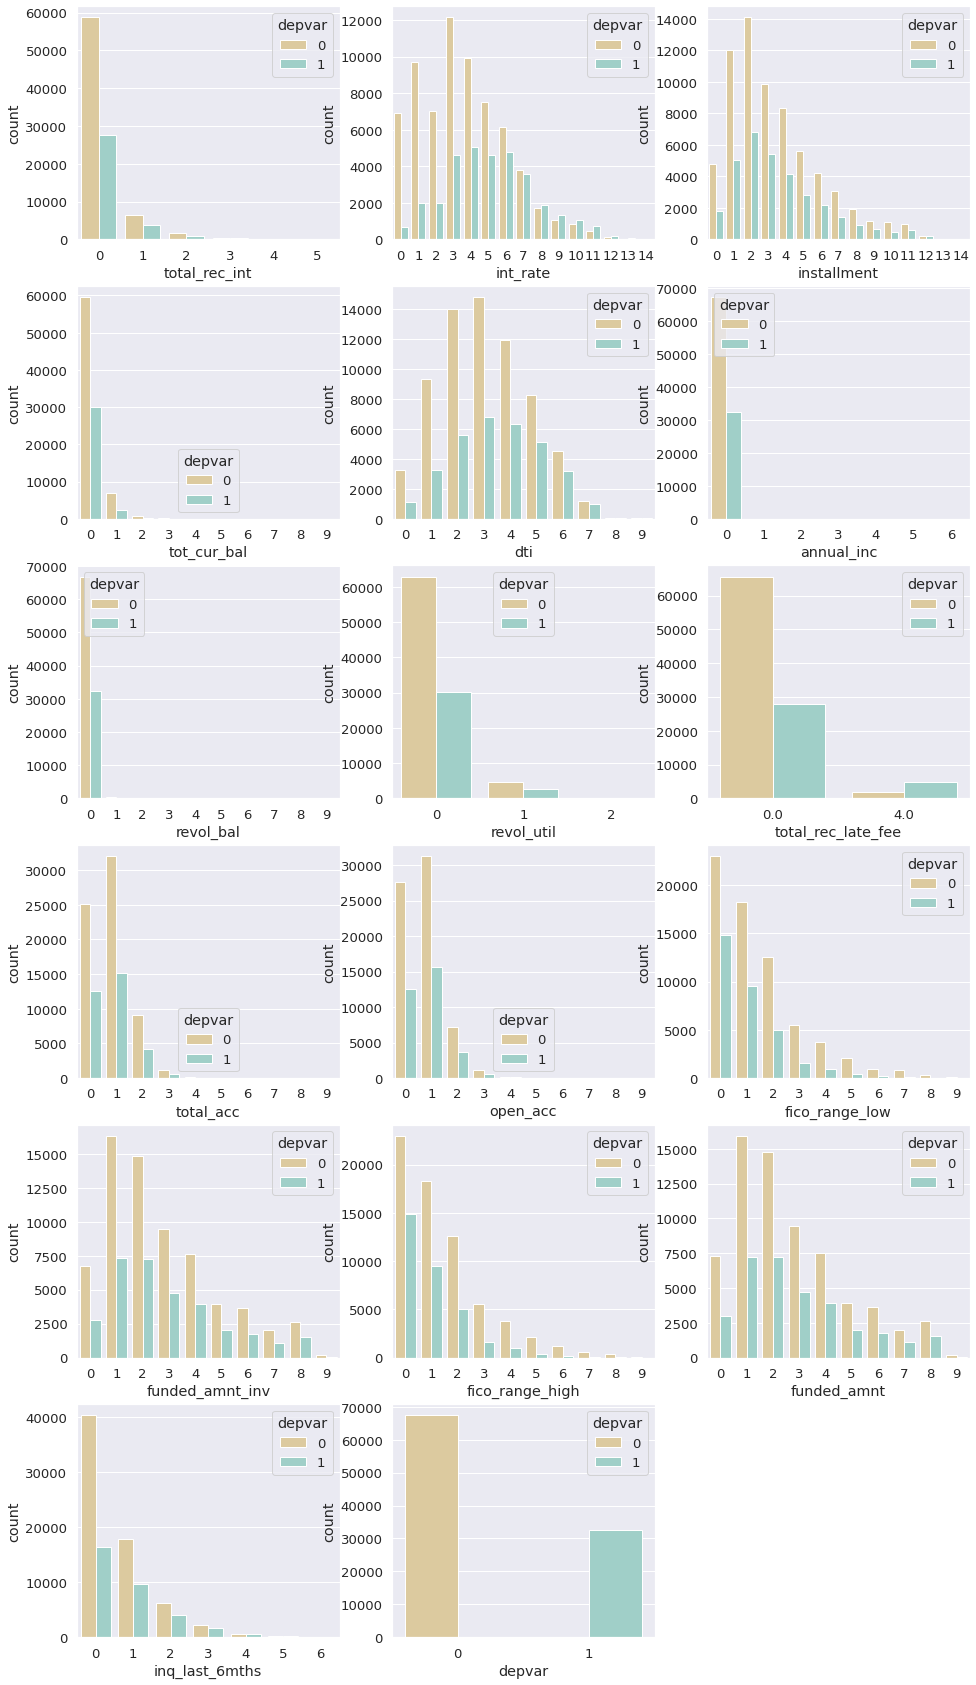

In [ ]:
plt.figure(figsize=(16, 30))
sns.set(font_scale=1.2)
sns.set_style('darkgrid') #'whitegrid', 'ticks', 'white', 'dark'

# 전체 17개 feature에 대해서 그래프 그림
for i, feature in enumerate(col_list):
    plt.subplot(6, 3, i+1)
    sns.countplot(data=df3, x=feature, hue='depvar', palette='BrBG')

In [ ]:
# 원핫인코딩으로 바꿔줌
df4 = pd.get_dummies(df3, columns=col_list[:-1])
df4.columns

Index(['depvar', 'total_rec_int_0', 'total_rec_int_1', 'total_rec_int_2',
       'total_rec_int_3', 'total_rec_int_4', 'total_rec_int_5', 'int_rate_0',
       'int_rate_1', 'int_rate_2',
       ...
       'funded_amnt_7', 'funded_amnt_8', 'funded_amnt_9', 'inq_last_6mths_0',
       'inq_last_6mths_1', 'inq_last_6mths_2', 'inq_last_6mths_3',
       'inq_last_6mths_4', 'inq_last_6mths_5', 'inq_last_6mths_6'],
      dtype='object', length=147)

In [ ]:
# Train, Valid split
X = df4.drop('depvar', axis=1)
y = df4['depvar']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

## Resid Feature 시각화

In [ ]:
# 상위 Top Feature 추출하고, 나머지 columns도 분석
_, col_list_top = ext_top_feat(df, fi, 16)

col_resid_list =list(df.columns)
for i, name in enumerate(col_list_top):
    col_resid_list.remove(name)
col_resid_list.append('depvar')

In [ ]:
#df = 모든 정보가 담긴 DataFrame
#df2_resid = 중요도있는 Feature 제외한 나머지 Feature들로 이루어진 DaraFrame
df2_resid = df[col_resid_list]

In [ ]:
df2_resid.nunique()
# nunique갯수 많은 tot_coll_amt , delinq_amnt 2개만 cut으로 구간 나눠줄예정

In [ ]:
# 시각화 한것 보고 특정값 이상 max로 치환하고 다시 구간 나누기
df2_resid.loc[df2_resid['tot_coll_amt']>0.00008, 'tot_coll_amt'] = 0.00008
df2_resid.loc[df2_resid['delinq_amnt']>0.001, 'delinq_amnt'] = 0.001

In [ ]:
# 구간 나눠주기
auxtot_coll_amt = pd.cut(df2_resid['tot_coll_amt'], 10)
auxdelinq_amnt = pd.cut(df2_resid['delinq_amnt'], 10)

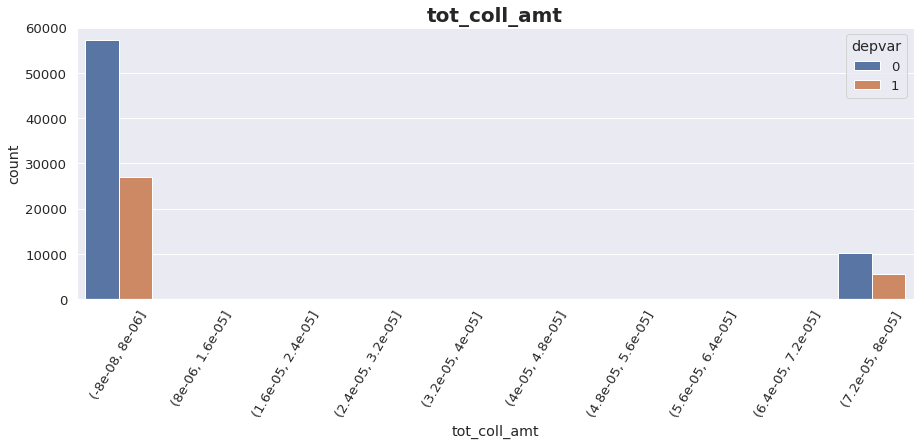

In [ ]:
# 0과 나머지로 구분예정
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxtot_coll_amt, hue='depvar', data=df2_resid).set_title("tot_coll_amt",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [ ]:
# 의미없는 컬럼, 분석시 제외예정
fig, axs = plt.subplots(figsize=(15, 5))
sns.countplot(x=auxdelinq_amnt, hue='depvar', data=df2_resid).set_title("delinq_amnt",fontdict= { 'fontsize': 20, 'fontweight':'bold'})
plt.xticks(rotation=60)
plt.show()

In [ ]:
# tot_coll_amt 3구간으로 나눠줌
df2_resid.loc[df2_resid['tot_coll_amt'] <= 0.00001, 'tot_coll_amt'] = 0
df2_resid.loc[(df2_resid['tot_coll_amt'] > 0.00001) & (df2_resid['tot_coll_amt'] <= 0.02), 'tot_coll_amt'] = 1
df2_resid.loc[df2_resid['tot_coll_amt']  > 0.02, 'tot_coll_amt'] = 2

df2_resid.loc[df2_resid['delinq_2yrs'] <= 4, 'delinq_2yrs'] = 0                                     #4년이하 2:1 비율
df2_resid.loc[(df2_resid['delinq_2yrs'] > 4) & (df2_resid['delinq_2yrs'] <= 10), 'delinq_2yrs'] = 1 #5~8년 채무불이행비율 증가
df2_resid.loc[df2_resid['delinq_2yrs']  > 10, 'delinq_2yrs'] = 2                                    #9년 이상

df2_resid.loc[df2_resid['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0     # 0번 추심 발생횟수
df2_resid.loc[df2_resid['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1     # 1번 이상

df2_resid.loc[df2_resid['tax_liens'] <= 0.1, 'tax_liens'] = 0                                   #0번 세금 저당권 2:1 비율
df2_resid.loc[(df2_resid['tax_liens'] > 0.1) & (df2_resid['tax_liens'] <= 1.5), 'tax_liens'] = 1 #1번 채무불이행비율 증가
df2_resid.loc[df2_resid['tax_liens']  > 1.5, 'tax_liens'] = 2 

In [ ]:
#df2에서 Label처리 한것
df3_resid = df2_resid.copy()

In [ ]:
# resid는 대부분 원핫벡터나 어느정도 숫자가 몇개안되는 애들임
# tot_coll_amt는 값처리해줬고, delinq_amnt는 의미없는 벡터라 삭제
# 밑에 크로스탭 결과로 'out_prncp', 'out_prncp_inv' 추가 삭제
df3_resid = df3_resid.drop(columns=['delinq_amnt', 'out_prncp', 'out_prncp_inv', 'acc_now_delinq'])

In [ ]:
df3_resid

,delinq_2yrs,pub_rec,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,chargeoff_within_12_mths,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,term1,depvar
0,0,0,0,0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
4,0,2,0,0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,1,0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1
99996,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
99997,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0
99998,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1


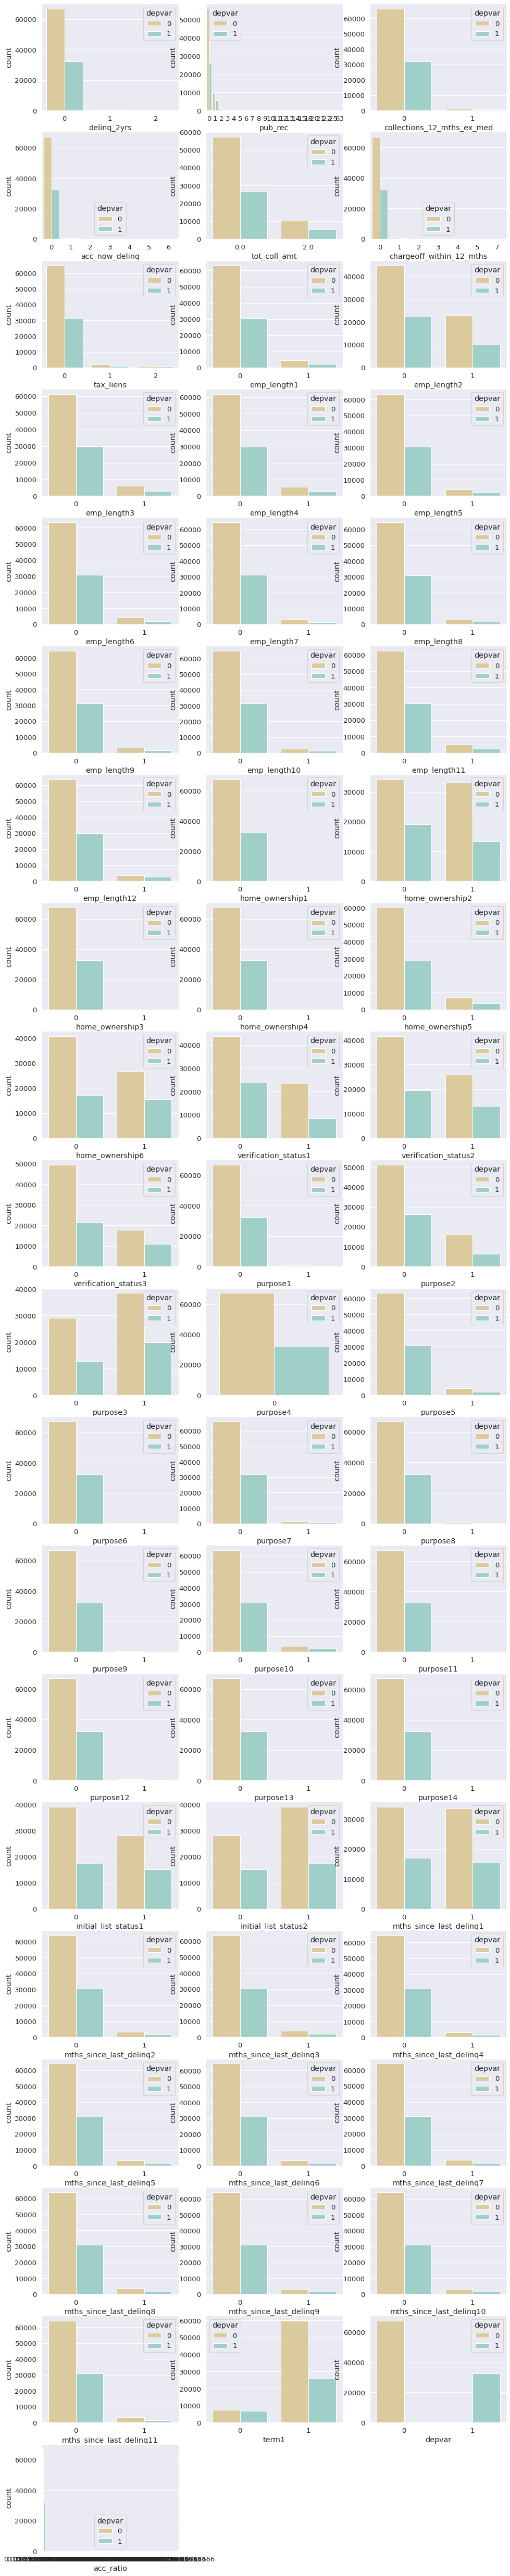

In [ ]:
# col_resid_list2 는 아까 삭제한 칼럼 뺴준 것
col_resid_list2 = list(df3_resid.columns)

plt.figure(figsize=(16, 90))
sns.set(font_scale=1.2)
sns.set_style('darkgrid') #'whitegrid', 'ticks', 'white', 'dark'

# col_resid_list = 56개 feature + 1개 결과값
for i, feature in enumerate(col_resid_list2):
    plt.subplot(20, 3, i+1)
    sns.countplot(data=df3_resid, x=feature, hue='depvar', palette='BrBG')

In [ ]:
# 위에서 시각화했던 값 수치 실제로 확인 크로스탭
for col in col_resid_list2[:]:
    print(pd.crosstab(df3_resid[col], df3_resid['depvar']))


depvar           0      1
delinq_2yrs              
0            66948  32256
1              453    292
2               30     21
depvar       0      1
pub_rec              
0        55997  26002
1         9332   5390
2         1373    770
3          417    229
4          159     91
5           79     40
6           31     24
7           14      9
8            9      4
9            3      0
10           7      3
11           2      1
12           1      1
13           1      1
14           2      1
15           0      1
18           1      0
20           1      0
21           0      1
22           1      0
25           0      1
63           1      0
depvar                          0      1
collections_12_mths_ex_med              
0                           66366  31924
1                            1065    645
depvar              0      1
acc_now_delinq              
0               67075  32384
1                 338    176
2                  15      6
3                   2      1
4   